### Predicting Stroke Likelihood
By Michael Bono

For this project, I have decided to utilize health data to attempt to predict the likelihood of stroke. I will be adhering to the CRISP-DM process in finding solutions to the following questions:

1. People with which lifestyle choices (such as smoking, marital status, work type and place of residence) suffer strokes most often?
2. How much of an impact do pre-existing health conditions have on likelihood of stroke?
3. How much does a single year increase likelihood of stroke?

#### Data Gathering/Importing/Loading
This dataset was sourced from Kaggle (https://www.kaggle.com/fedesoriano/stroke-prediction-dataset/version/1).

In [332]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
%matplotlib inline
%reload_ext autoreload
%autoreload 2

df = pd.read_csv('./healthcare-dataset-stroke-data.csv')

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Looks like the data loaded in just fine. We can see 12 fields comprising of boolean, categorical and numerical variables. Let's begin some primary assessments of the data.

#### Data Assessing
Let's begin by checking out the shape of the dataset and which fields have null values. 

In [333]:
df.shape

(5110, 12)

In [334]:
np.sum(df.isnull()) == 0

id                    True
gender                True
age                   True
hypertension          True
heart_disease         True
ever_married          True
work_type             True
Residence_type        True
avg_glucose_level     True
bmi                  False
smoking_status        True
stroke                True
dtype: bool

Looks like we've got 5,110 observations and only BMI has some null values - and this is a quantitative field. This shouldn't be too difficult to fix. Let's find out how many. 

In [335]:
np.sum(df.bmi.isnull())

201

201 null values in the BMI column, or approximately 4% of the data. We can deal with this later. For now, let's take a look at some of the quantitative variables.

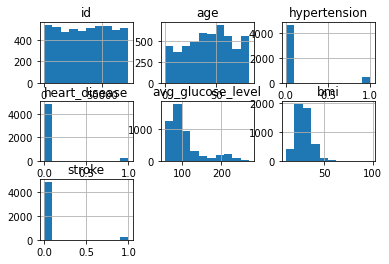

In [336]:
df.hist();

In [337]:
df.stroke.sum()/df.shape[0]*100

4.87279843444227

The 'id' field is meaningless in terms of our analysis. We will probably drop this later. In terms of the other fields, we can see a few things: hypertension, heart_disease, and stroke all look like boolean variables. We have a wide variety of ages.  BMI appears normally distributed, though it may have some outliers. avg_glucose level looks primarily normally distributed on the lower end of the graph, but with a small spike in some higher values.

One additional thing to note is that it looks like the variable we will try to predict, 'stroke', has a small proportion of 1 values (just under 5%). This may impact our ability to create a strong model. For now, let's dig into BMI just a little bit more.

In [338]:
np.sum(df.bmi>70)

4

In [339]:
df[df.bmi>70]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
544,545,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
928,41097,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0
2128,56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
4209,51856,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0


There's not a lot of BMI values above 70, and none of them suffered a stroke. These outliers could potentially throw some things off. We will probably get rid of these later, but let's take a look at the qualitative variables.

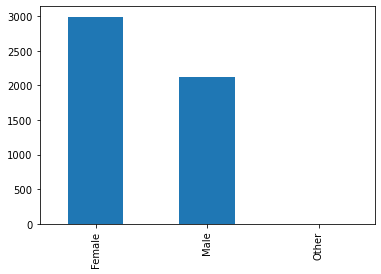

In [340]:
df.gender.value_counts().plot(kind = "bar");

In [341]:
df[df.gender == "Other"]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


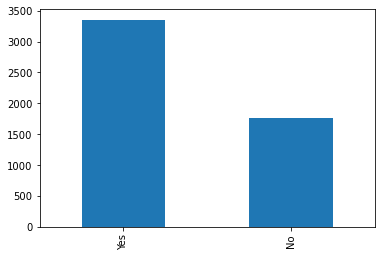

In [342]:
df.ever_married.value_counts().plot(kind = "bar");

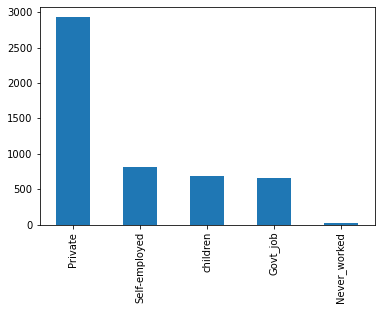

In [343]:
df.work_type.value_counts().plot(kind = "bar");

In [344]:
df[df.work_type == "Never_worked"]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
253,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,Unknown,0
603,61408,Male,23.0,0,0,No,Never_worked,Urban,125.26,18.7,never smoked,0
886,13948,Female,19.0,0,0,No,Never_worked,Urban,86.96,25.8,never smoked,0
939,16556,Male,13.0,0,0,No,Never_worked,Rural,111.48,20.8,Unknown,0
959,56986,Male,17.0,0,0,No,Never_worked,Urban,113.25,23.4,never smoked,0
1462,41870,Male,17.0,0,0,No,Never_worked,Rural,61.01,32.5,Unknown,0
1789,13862,Female,13.0,0,0,No,Never_worked,Urban,70.93,22.9,never smoked,0
1922,51935,Male,16.0,0,0,No,Never_worked,Urban,59.99,28.2,never smoked,0
2346,61219,Female,14.0,0,0,No,Never_worked,Urban,148.37,22.7,never smoked,0
2721,23508,Female,17.0,0,0,No,Never_worked,Rural,88.57,31.1,never smoked,0


In [345]:
df[df.work_type == "Never_worked"].shape

(22, 12)

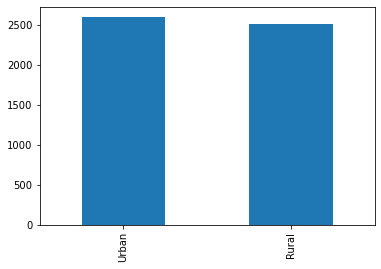

In [346]:
df.Residence_type.value_counts().plot(kind = "bar");

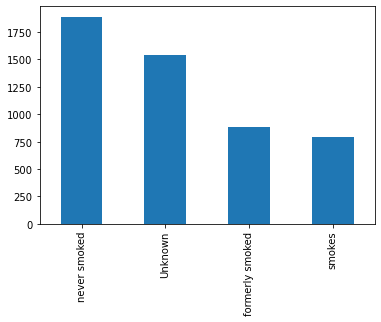

In [347]:
df.smoking_status.value_counts().plot(kind = "bar");

Everything looks mostly straightforward. I noticed an "Other" category for Gender that looks to only have one observation. This person did not have a stroke. We may end up removing this observation for model simplicity. I also noticed that there are only 22 observations of instances where the patient never worked. None of these patients had a stroke. This category may also get removed for simplicity. smoking_status has a field called "Unknown" that we didn't initially pick up because it was not Null. It has way too many observations to just throw them out, but because there are so many, I'm worried about replacing it with a new value. I will keep it in the dataset as is, and try to set it as the base value when we do our regression.

#### Data Cleaning
Now we can get into the data cleaning process. We have some outliers to remove, and some categories that just did not have enough data to be valuable and will probably end up adding complexity into the model. Let's get started!

In [348]:
#replacing NA values in BMI
new_df = df
new_df['bmi'] = new_df['bmi'].fillna(new_df.bmi.mean())

#removing our bmi outliers and categories that are too small
new_df = new_df[new_df.bmi<70]
new_df = new_df[new_df.gender != 'Other'] 
new_df = new_df[new_df.work_type != "Never_worked"]

#drop id - we don't need this for our regression
new_df = new_df.drop(['id'], axis = 1)

#checking new data shape
new_df.shape

(5083, 11)

In [349]:
df.shape

(5110, 12)

We removed a total of 27 observations from our dataset. All NAs are now gone as well! Time to analyze our data a little further.

#### Analyze Data
We'll jump into data analysis now. In this step, we'll make sure our data is suitable for regression, and we'll also see if we can answer our first question (People with which lifestyle choices (such as smoking, marital status, work type and place of residence) suffer strokes most often?). 

We will start by subsetting the data to stroke victims, and then generate the percentage of people per subcategory that had a stroke. This accounts for any differences in representation within the population (for example, if we have 1000 non-smokers and 100 smokers, and there are 50 non-smokers stroke victimes and 50 smoker stroke victimes, we don't want to show these as equal on a bar chart. We instead will show that 5% of non-smokers had strokes and 50% of smokers had strokes). 

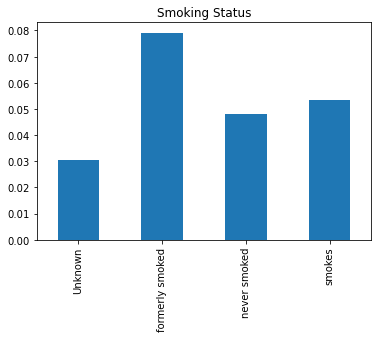

In [350]:
#subset data to only stroke victims
stroke_df = df[df.stroke == 1]

(stroke_df.smoking_status.value_counts()/new_df.smoking_status.value_counts()).plot(kind = "bar");
plt.title("Smoking Status");

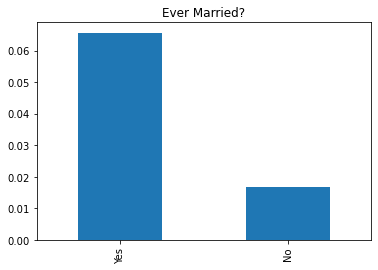

In [351]:
(stroke_df.ever_married.value_counts()/new_df.ever_married.value_counts()).plot(kind = "bar");
plt.title("Ever Married?");

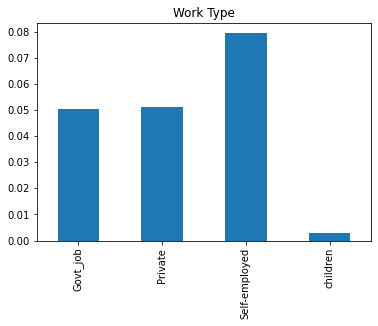

In [352]:
(stroke_df.work_type.value_counts()/new_df.work_type.value_counts()).plot(kind = "bar");
plt.title("Work Type");

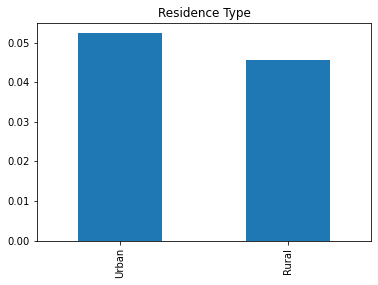

In [353]:
(stroke_df.Residence_type.value_counts()/new_df.Residence_type.value_counts()).plot(kind = "bar");
plt.title("Residence Type");

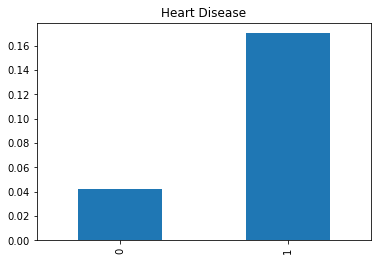

In [354]:
(stroke_df.heart_disease.value_counts()/new_df.heart_disease.value_counts()).plot(kind = "bar");
plt.title("Heart Disease");

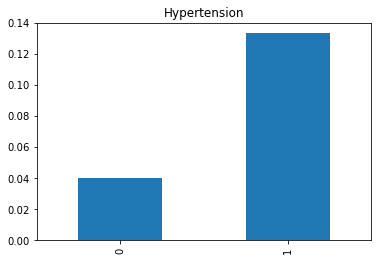

In [355]:
(stroke_df.hypertension.value_counts()/new_df.hypertension.value_counts()).plot(kind = "bar");
plt.title("Hypertension");

We can see a few interesting things from these plots that answer our first question. It appears that individuals who were self employed, married, and formerly smoked all had more strokes than individuals from other categories. It is interesting that individuals who formerly smoked suffered strokes more often than those who are current smokers - we can continue to investigate this within our regression.

We also get some info on our second question about the impact of pre-existing health conditions on stroke likelihood. While we don't know the exact impact, we can see that a much higher percentage of individuals with heart disease or hypertension are suffering strokes.

Let's look at some relationships between our quantitative data now to see if there are any relationships or trends between our variables.

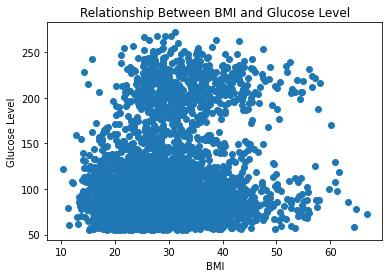

In [356]:
plt.scatter(new_df.bmi, new_df.avg_glucose_level);
plt.xlabel("BMI");
plt.ylabel("Glucose Level");
plt.title("Relationship Between BMI and Glucose Level");

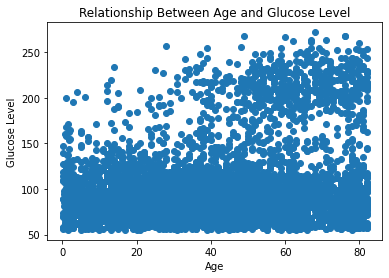

In [357]:
plt.scatter(new_df.age, new_df.avg_glucose_level);
plt.xlabel("Age");
plt.ylabel("Glucose Level");
plt.title("Relationship Between Age and Glucose Level");

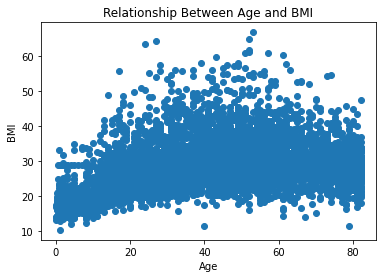

In [358]:
plt.scatter(new_df.age, new_df.bmi);
plt.xlabel("Age");
plt.ylabel("BMI");
plt.title("Relationship Between Age and BMI");

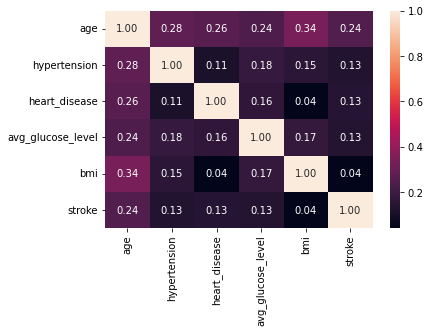

In [359]:
sns.heatmap(new_df.corr(), annot=True, fmt=".2f");

I checked out a few scatter plots between quantitative variables and didn't see any strong trends between the data. I also ran a correlation matrix just to verify our predictors are independent. Looks like they are, and we are set to move on to the modeling step!

#### Modeling - Logistic Regression
I am going to utilize a logistic regression model to predict the outcome (stroke occurrence). I will start by splitting the data into training and testing sets.

In [360]:
def create_dummy_df(df, cat_cols, dummy_na):
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

cat_df = new_df.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns

final_df = create_dummy_df(new_df, cat_cols_lst, dummy_na=False)
final_df.head()


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Male,ever_married_Yes,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,228.69,36.600000,1,1,1,1,0,0,1,1,0,0
1,61.0,0,0,202.21,28.893237,1,0,1,0,1,0,0,0,1,0
2,80.0,0,1,105.92,32.500000,1,1,1,1,0,0,0,0,1,0
3,49.0,0,0,171.23,34.400000,1,0,1,1,0,0,1,0,0,1
4,79.0,1,0,174.12,24.000000,1,0,1,0,1,0,0,0,1,0


In [361]:
#set up data for split
X = final_df[['age','hypertension','heart_disease','avg_glucose_level','bmi','gender_Male','ever_married_Yes','work_type_Private','work_type_Self-employed','work_type_children','Residence_type_Urban','smoking_status_formerly smoked','smoking_status_never smoked', 'smoking_status_smokes']]
y = final_df['stroke']

#split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state = 1776)

logreg = LogisticRegression(class_weight = 'balanced', max_iter = 1000) #use this to account for our small minority class

#fit model
logreg.fit(X_train, y_train)

#check out predictions
y_test_preds = logreg.predict(X_test)
y_train_preds = logreg.predict(X_train)

I've fit the model and now it's time to take a look at it! Let's visualize and interpret our results.

#### Visualize and Interpret Results

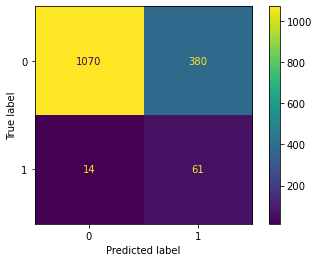

In [362]:
#show results of testing data in a confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_test_preds))
disp.plot()
plt.show()

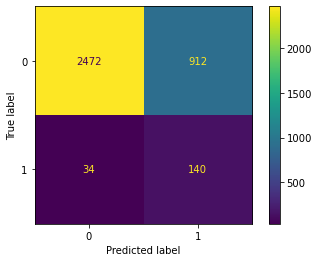

In [363]:
#check out results of training data in a confusion matrix for reference
disp2 = ConfusionMatrixDisplay(confusion_matrix(y_train, y_train_preds))
disp2.plot()
plt.show()

We can see that neither of these models predicted the minority class very effectively, due to the proportional size of our minority class. In a future model, we may need to explore different algorithms like SMOTE or strategic sampling so that our model can more accurately predict stroke occurrences. Currently, the model is very adept at predicting those who will NOT have a stroke.

In [364]:
logreg.coef_.tolist()

[[0.08315503802958107,
  0.5015196660532596,
  0.06386252281392019,
  0.0034191387985912677,
  0.01338519496579246,
  -0.22306557683018075,
  0.05211461581213512,
  0.17372970330387735,
  -0.04109617904055795,
  1.3832133164520617,
  -0.011950351749111595,
  0.018864657080793434,
  -0.20358065226806382,
  0.4867177112778294]]

In [365]:
X_train.columns.tolist()

['age',
 'hypertension',
 'heart_disease',
 'avg_glucose_level',
 'bmi',
 'gender_Male',
 'ever_married_Yes',
 'work_type_Private',
 'work_type_Self-employed',
 'work_type_children',
 'Residence_type_Urban',
 'smoking_status_formerly smoked',
 'smoking_status_never smoked',
 'smoking_status_smokes']

The coefficient output shows us the expected change in log odds of having the outcome pet unit change. More explicitly, the coefficient x, when put into the formula e^x, returns the odds ratio of the predicted outcome happening. We can immediately see that any negative coefficient reduces the odds of stroke likelihood, while any positive ones increase the likelihood. 

The following features decrease stroke likelihood based on the model:
   - gender_Male
   - work_type_Self-employed
   - Residence_type_Urban
   - smoking_status_never smoked
   
The remaining features increase the likelihood.

#### Conclusion

Through this process, we were able to answer our questions:

1. People with which lifestyle choices (such as smoking, marital status, work type and place of residence) suffer strokes most often?
 -  It appears that individuals who were self employed, married, and formerly smoked all had more strokes than individuals from other categories.
2. How much of an impact do pre-existing health conditions have on likelihood of stroke?
 -  Hypertension increases likelihood by 65%. Heart disease increases likelihood by 6%.
3. How much does a single year increase likelihood of stroke?
 -  Each year, stroke likelihood increases by e^0.083155, or 8.6% higher than the year before.
    
This analysis could be expanded to include a larger dataset with more observations of stroke occurrences, additional data points around health including cholesterol and stress levels, as well as incorporation of SMOTE algorithms to increase presence of the minority of the class.